<a href="https://colab.research.google.com/github/nikitaoltyan/Mech-Trading-Systems/blob/main/Mech_Systems_Bot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Project cloning
!git clone https://github.com/nikitaoltyan/Mech-Trading-Systems.git
%cd Mech-Trading-Systems

Cloning into 'Mech-Trading-Systems'...
remote: Enumerating objects: 185, done.
remote: Counting objects: 100% (185/185), done.
remote: Compressing objects: 100% (176/176), done.
remote: Total 185 (delta 91), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (185/185), 311.89 KiB | 3.58 MiB/s, done.
Resolving deltas: 100% (91/91), done.
/content/Mech-Trading-Systems


In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [17]:
from classifiers.HeadWithShoulders import head_with_shoulders
from classifiers.Trend import find_rising_trend_lines, find_decreasing_trend_lines, draw_trends
from classifiers.Triangle import find_triangle, draw_triangles
from PlotDraw import draw_plot
from levels import levels, levelplot

In [ ]:
data = pd.read_excel("Boeing_Data.xlsx")
data.head()

,<DATE>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,2015-01-02,130.94,131.84,129.10,129.96,314405
1,2015-01-05,129.43,129.83,128.61,129.09,375840
2,2015-01-06,128.85,129.61,126.20,127.69,274113
3,2015-01-07,128.83,129.96,128.74,129.47,207999
4,2015-01-08,130.60,131.98,130.48,131.83,206594


In [ ]:
l = levels()
l.find_support(data)

In [ ]:
decreasing_trends = find_decreasing_trend_lines(data, 4, 5)
decreasing_trends

In [24]:
def support_breaking(data, supports, trends):
  sup_arr = [index[0] for index in supports]
  #for support in supports:
  print(sup_arr)
  for trend in trends:
    print(trend)

In [28]:
supports = l.find_support(data)
trends = find_decreasing_trend_lines(data, 4, 5)

In [38]:
sup_arr = [index[0] for index in supports]

In [35]:
def findLastIndex(trendIndex):
    index = 0
    while sup_arr[index] < trendIndex:
        index += 1
    return index-1

In [37]:
findLastIndex(100)

5

In [65]:
low = data["<LOW>"]
close = data["<CLOSE>"]

In [138]:
def findClosePosition(openIndex, money, boughtIndex, alpha, beta, lenth):
    #print(f"Open index: {openIndex}, Price: {close[openIndex]}")
    if boughtIndex > openIndex:
        return (money, 0, boughtIndex)
    index = openIndex
    openPrice = close[openIndex]
    sharesBought = money // openPrice
    rest = money - (openPrice * sharesBought)
    while (openPrice/close[index] < (1+alpha)) and (openPrice/close[index] > (1-beta)):
        if lenth-1 > index:
            index += 1
        else:
            break
    #print(f"Close. Open price: {openPrice}, close price: {close[index]}")
    available = True
    profit = round(sharesBought*openPrice - sharesBought*close[index], 2)
    money = profit + money + rest
    # print(sharesBought, money, profit)
    return (money, profit, index)

In [117]:
def findOpenPositionIndexes(trends):
    openPositionIndexes = []
    for trend in trends:
        trendStart = trend[2]
        lastSupport = findLastIndex(trendStart)
        supLow = low[sup_arr[lastSupport]]
        if supLow > low[trendStart]:
            #print("Pass")
            pass
        else:
            for index in range (trendStart, trendStart+10):
                if supLow > low[index]:
                    # print(f"Open position, {supLow, low[i], trendStart, index}")
                    if len(openPositionIndexes) == 0:
                        openPositionIndexes.append(index)
                        break
                    if index > openPositionIndexes[-1]:
                        openPositionIndexes.append(index)
                        break
  
    return openPositionIndexes

In [139]:
pos = findOpenPositionIndexes(trends)
prof = 0
money = 100000
bI = 0
for i in pos:
    mon, profit, boughtIndex = findClosePosition(i, money, bI, 0.03, 0.001, data.shape[0])
    money = mon
    bI = boughtIndex
    prof += profit
prof

24884.940000000002

In [184]:
alphas = [0, 0.1]
betas = [0, 0.1]
pos = findOpenPositionIndexes(trends)
results = {}

for iter in range (1024):
    alpha = np.random.uniform(alphas[0], alphas[1])
    beta = np.random.uniform(betas[0], betas[1])
    # print(f"Iter: {iter}, coefs: {alpha, beta}")

    prof = 0
    money = 100000
    bI = 0
    for i in pos:
        mon, profit, boughtIndex = findClosePosition(i, money, bI, alpha, beta, data.shape[0])
        money = mon
        bI = boughtIndex
        prof += profit
    results[prof] = (alpha, beta)
    # print(prof)
print(f"Max profit: {max(results)} was received by alpha and beta: {results[max(results)]}")

Max profit: 37889.05000000001 was received by alpha and beta: (0.02669712521045188, 2.9714936213409705e-05)


Text(0.5, 1.0, 'Profit distribution')

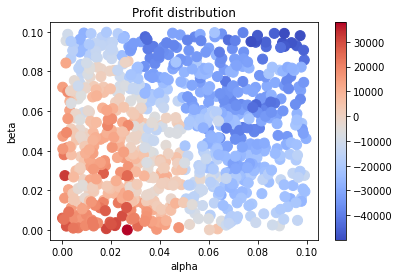

In [185]:
x_scatter = [results[x][0] for x in results]
y_scatter = [results[x][1] for x in results]


marker_size = 100
colors = [x for x in results]
plt.tight_layout(pad=1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('alpha')
plt.ylabel('beta')
plt.title('Profit distribution')